In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from matplotlib.cm import rainbow
from joblib import Parallel, delayed

from scipy.stats import pearsonr

In [2]:
input_data = pd.read_csv('STORAGE_data/es-1min_FULL.csv')
input_data.index = pd.to_datetime(input_data.date + ' ' + input_data.time)
input_data

,date,time,open,high,low,close
2011-12-19 09:30:00,12/19/2011,9:30:00,1215.875,1216.375,1215.625,1215.875
2011-12-19 09:31:00,12/19/2011,9:31:00,1215.875,1217.125,1215.875,1217.125
2011-12-19 09:32:00,12/19/2011,9:32:00,1217.125,1217.875,1217.125,1217.625
2011-12-19 09:33:00,12/19/2011,9:33:00,1217.625,1218.375,1217.625,1218.125
2011-12-19 09:34:00,12/19/2011,9:34:00,1218.125,1218.375,1217.625,1217.875
...,...,...,...,...,...,...
2015-12-16 16:10:00,12/16/2015,16:10:00,2070.125,2070.375,2069.875,2070.125
2015-12-16 16:11:00,12/16/2015,16:11:00,2070.125,2070.875,2069.125,2069.250
2015-12-16 16:12:00,12/16/2015,16:12:00,2069.250,2072.125,2069.125,2072.125
2015-12-16 16:13:00,12/16/2015,16:13:00,2072.125,2072.625,2071.625,2072.000


In [3]:
data = input_data.drop(['date', 'time'], axis=1)

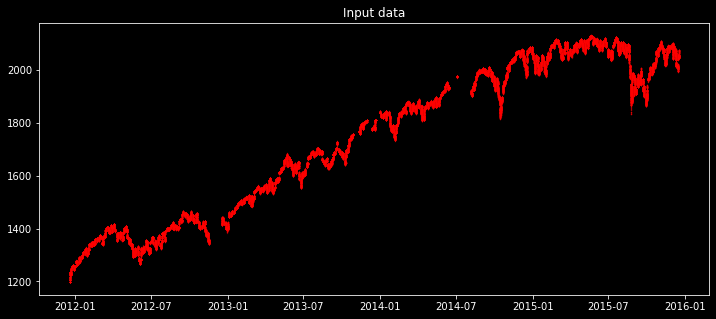

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(data.close, 'o', markersize=.3, color='red', alpha=.6)
plt.title('Input data')
plt.show()

In [5]:
def pearson_corr(a,b):
    """
    Better to use scipy
    :param a:
    :param b:
    :return:
    """
    a_hat = np.mean(a)
    b_hat = np.mean(b)
    return np.sum(np.subtract(a, a_hat) * np.subtract(b, b_hat)) / np.sqrt(np.sum(np.square(np.subtract(a, a_hat))) * np.sum(np.square(np.subtract(b, b_hat))))

def _start_duplicates_removing(inp_data):
    #   Clean duplicates
    ret_data = inp_data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    #   Check success of cleaning
    assert len(ret_data.index) == len(ret_data.index.unique())
    print(f'Duplicates at {1 - (ret_data.shape[0] / inp_data.shape[0]):.2%} of data')
    return ret_data

def normalize_data(inp_data: pd.DataFrame, show=True):
    #   Calculate the right numbers of observations intra day
    NORMAL_MINUTES = (15 - 9) * 60 + 59 - 29
    #   Checks for duplicates
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(12,8))
        plt.subplot(2,1,1)
        plt.plot(inp_data.close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Input data')

    if len(inp_data.index) != len(inp_data.index.unique()):
        inp_data = _start_duplicates_removing(inp_data)
    #   In data not of all information about trade-day. For example at date 2011-12-19 data ends at 15:59. At date 2015-12-19 data ends at 16:14. Notice that normal trade day ends at 16:30.
    #   At start lets drop lines with days with zero observations.
    mask = ~np.in1d(inp_data.index.date,inp_data.resample('1D').count().query(f'open < {NORMAL_MINUTES}').index.date)

    if show:
        plt.subplot(2,1,2)
        plt.plot(inp_data.loc[mask,:].close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Cut data')
        plt.show()
    #   Shows percent of "bad" dotes
    print(f"Bad days at {1 - (len(mask) / len(inp_data)):.2%} observations")
    return inp_data.loc[mask,:]


Duplicates at 6.18% of data
Bad days at 0.00% observations


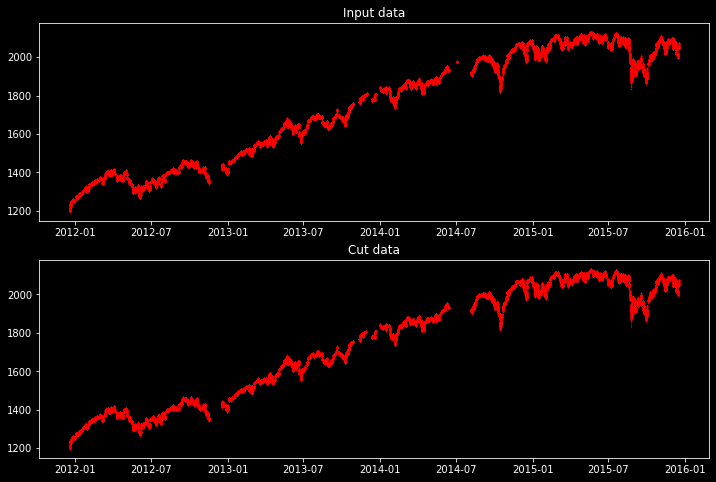

In [19]:
preprocessed_data = normalize_data(data).close.values

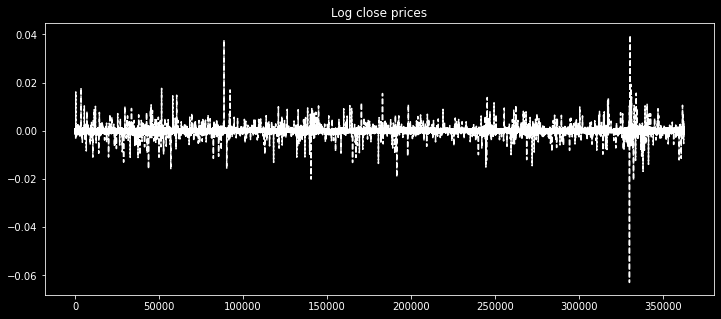

In [12]:
preprocessed_data = np.log((preprocessed_data / np.roll(preprocessed_data, 1))[1:])
plt.figure(figsize=(12,5))
plt.title('Log close prices')
plt.plot(preprocessed_data, '--', color='white')
plt.show()

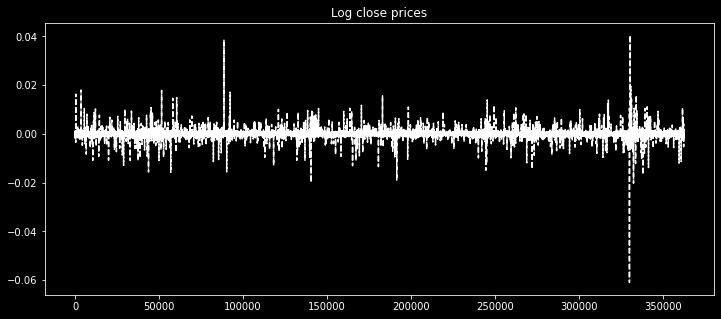

In [20]:
preprocessed_data = (np.diff(preprocessed_data) / preprocessed_data[:-1])[1:]
plt.figure(figsize=(12,5))
plt.title('Log close prices')
plt.plot(preprocessed_data, '--', color='white')
plt.show()


In [8]:
"""
CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
_LOOKBACK_MASK_ = np.arange(20, 2000, 5)
_HOLD_MASK_ = np.arange(20, 2000, 5)
LB_SIMPLIFY = 10
for WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc='WINDOWS_LOOKBACK'):
    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
    for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc='WINDOW_HOLD'):
        HOLD_ALL_DATA = list()
        LOOKBACK_ALL_DATA = list()
        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                # print('READY')
                # print(LB_SAMPLE)
                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                # print(WINDOW_HOLD)
                # print(len(preprocessed_data))
                break
            else:
                #   View like [ 20000 20020 ][ 20020 20040 ]
                LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                HOLD_ALL_DATA.append(sum(HOLD))
                LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
            #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')
        PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
        CORRELATION_DF = CORRELATION_DF.append([{'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]}], ignore_index=True)
CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)
"""

'\nCORRELATION_DF = pd.DataFrame(columns=[\'Pair\',\'LOOKBACK\',\'HOLD\',\'Correlation\', \'P_VALUE\'])\n_LOOKBACK_MASK_ = np.arange(20, 2000, 5)\n_HOLD_MASK_ = np.arange(20, 2000, 5)\nLB_SIMPLIFY = 10\nfor WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc=\'WINDOWS_LOOKBACK\'):\n    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK\n    for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc=\'WINDOW_HOLD\'):\n        HOLD_ALL_DATA = list()\n        LOOKBACK_ALL_DATA = list()\n        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):\n            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):\n                # print(\'READY\')\n                # print(LB_SAMPLE)\n                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)\n                # print(WINDOW_HOLD)\n                # print(len(preprocessed_data))\n                break\n            else:\n                #   View like [ 20000 20020 ][ 20020 20040 ]\n                LOOKBACK = preprocessed_data[LB_S

In [45]:
def create_corr_table(preprocessed_data):
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(20, 1200, 15)
    _HOLD_MASK_ = np.arange(20, 1200, 15)
    LB_SIMPLIFY = 100
    for WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc='WINDOWS_LOOKBACK'):

        LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
        for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc='WINDOW_HOLD'):
            HOLD_ALL_DATA = list()
            LOOKBACK_ALL_DATA = list()
            for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
                if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                    # print('READY')
                    # print(LB_SAMPLE)
                    # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                    # print(WINDOW_HOLD)
                    # print(len(preprocessed_data))
                    break
                else:
                    #   View like [ 20000 20020 ][ 20020 20040 ]
                    LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                    HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                    HOLD_ALL_DATA.append(sum(HOLD))
                    LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
                #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')
            PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
            CORRELATION_DF = CORRELATION_DF.append([{'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]}], ignore_index=True)
    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)

df = create_corr_table(preprocessed_data=preprocessed_data)
df

WINDOWS_LOOKBACK:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
def creator(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY):
    RETURN_LIST = list()
    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK

    ### Not sure that works. Test
    if LB_SAMPLES<LB_SIMPLIFY:
        LB_SIMPLIFY = 1
    ###


    for WINDOW_HOLD in _HOLD_MASK_:
        HOLD_ALL_DATA = list()
        LOOKBACK_ALL_DATA = list()
        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                # print('READY')
                # print(LB_SAMPLE)
                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                # print(WINDOW_HOLD)
                # print(len(preprocessed_data))
                break
            else:
                #   View like [ 20000 20020 ][ 20020 20040 ]
                LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                HOLD_ALL_DATA.append(sum(HOLD))
                LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
            #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')

        try:
            PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
        except ValueError:
            print('Value Error')
            print(LOOKBACK_ALL_DATA)
            print(HOLD_ALL_DATA)
            print(LB_SAMPLES)
            print(LB_SIMPLIFY)
        RETURN_LIST.append({'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]})
    return RETURN_LIST

def threading_create_corr_table(preprocessed_data):
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(2, 200, 1)
    _HOLD_MASK_ = np.arange(2, 200, 1)
    LB_SIMPLIFY = 1000

    assets = Parallel(n_jobs=-1, verbose=10)(delayed(creator)(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY) for WINDOW_LOOKBACK in _LOOKBACK_MASK_)
    for _ in assets:
        for __ in _:
            CORRELATION_DF = CORRELATION_DF.append([__], ignore_index=True)

    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)

df2 = threading_create_corr_table(preprocessed_data=preprocessed_data)
#df2.query('Correlation < 0.7')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

In [16]:

df2

,Pair,LOOKBACK,HOLD,Correlation,P_VALUE
25755,L-132;H-17,132,17,0.748502,4.636760e-06
25754,L-132;H-16,132,16,0.741217,6.421321e-06
36990,L-188;H-164,188,164,0.740020,1.914080e-04
36989,L-188;H-163,188,163,0.731241,2.491020e-04
36992,L-188;H-166,188,166,0.728548,2.695294e-04
...,...,...,...,...,...
38020,L-194;H-6,194,6,-0.952951,3.065449e-10
38030,L-194;H-16,194,16,-0.953377,2.841891e-10
38024,L-194;H-10,194,10,-0.954779,2.202603e-10
38022,L-194;H-8,194,8,-0.961778,5.402580e-11


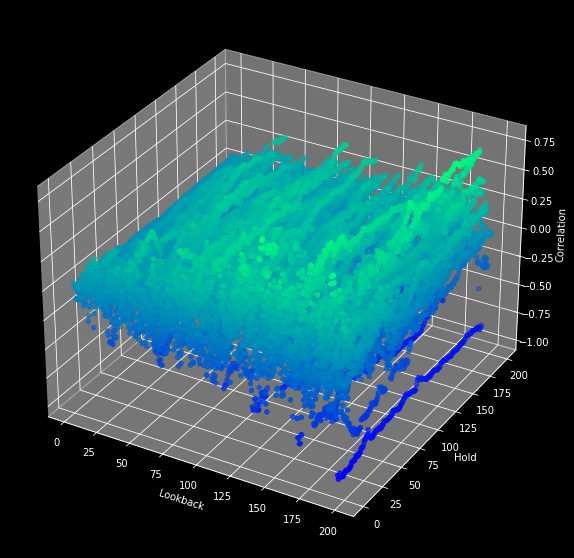

In [15]:
df = df2
from matplotlib import cm
ax = plt.figure(figsize=(18,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('Lookback')
ax.set_ylabel('Hold')
ax.set_zlabel('Correlation')
X, Y = np.meshgrid(df['LOOKBACK'].astype(float), df['HOLD'].astype(float))
ax.scatter(df['LOOKBACK'].astype(float), df['HOLD'].astype(float), df['Correlation'],c=df['Correlation'], cmap=plt.get_cmap('winter'))

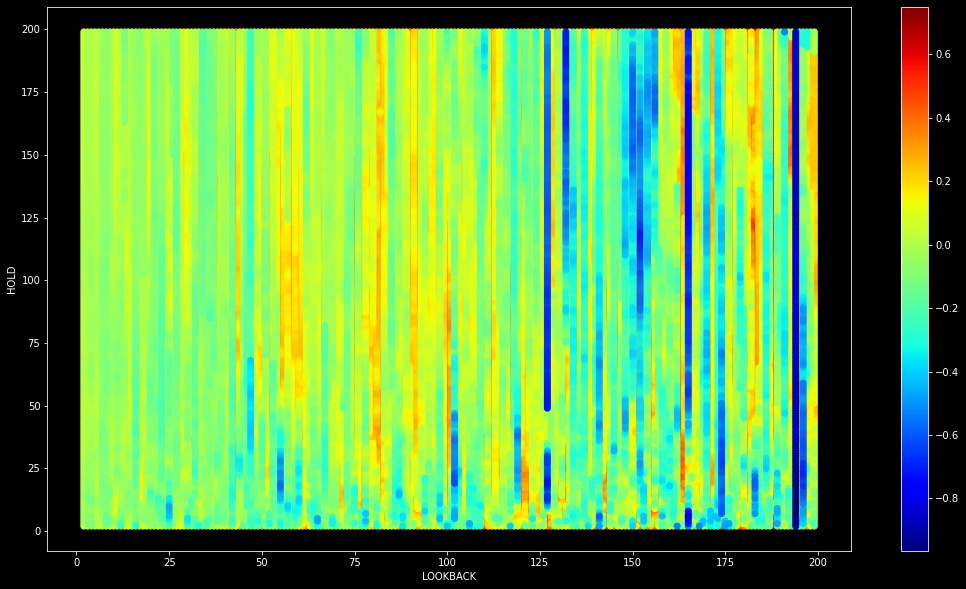

In [17]:
plt.figure(figsize=(18,10))
plt.scatter(df['LOOKBACK'].astype(int), df['HOLD'].astype(int), c=df['Correlation'], cmap=plt.get_cmap('jet'))
plt.xlabel('LOOKBACK')
plt.ylabel('HOLD')
plt.colorbar()


In [30]:
df

,Pair,LOOKBACK,HOLD,Correlation,P_VALUE
582,L-100;H-50,100,50,0.472874,0.003121
581,L-100;H-45,100,45,0.467447,0.003533
578,L-100;H-30,100,30,0.463258,0.003883
973,L-155;H-25,155,25,0.460199,0.023647
983,L-155;H-75,155,75,0.458936,0.024083
...,...,...,...,...,...
1066,L-165;H-130,165,130,-0.788981,0.000013
1070,L-165;H-150,165,150,-0.791409,0.000012
1072,L-165;H-160,165,160,-0.795266,0.000010
1071,L-165;H-155,165,155,-0.802228,0.000007


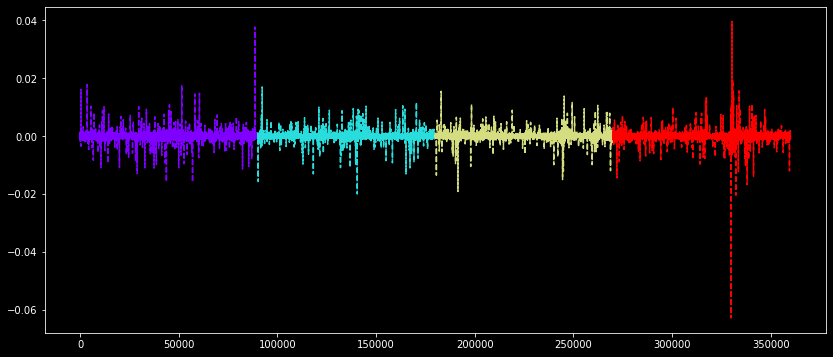

In [13]:
#   Testing that A U B == 0
plt.figure(figsize=(14,6))
LB_SIMPLIFY = 1
WINDOW_LOOKBACK = 90_000
LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
colors = rainbow(np.linspace(0,1, len(range(0, LB_SAMPLES, LB_SIMPLIFY))))
for i, LB_SAMPLE in enumerate(range(0, LB_SAMPLES, LB_SIMPLIFY)):
    LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
    plt.plot([j for j in range(LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK)], LOOKBACK,'--', color=colors[i])
plt.show()
